# Producción de H2V Distribuida - Modelo Punto por Punto

## 🎯 Objetivo
Calcular el **potencial de producción de hidrógeno verde (H2V)** en cada ubicación geográfica del Valle de Aconcagua.

## 🏗️ Arquitectura del Modelo
**Modelo DISTRIBUIDO**: 330 sistemas independientes (uno por punto de grilla)

```
Punto 1:  PV(CF=0.207) → Electrolyzer → H2_Storage → Demanda
Punto 2:  PV(CF=0.217) → Electrolyzer → H2_Storage → Demanda
...
Punto 330: PV(CF=0.253) → Electrolyzer → H2_Storage → Demanda
```

**Sin transmisión entre puntos** → Cada ubicación es evaluada independientemente

## 📊 Outputs
- Matriz espacial: `[lat, lon, cap_pv_mw, cap_electrolyzer_mw, h2_ton_year, lcoh_usd_kg]`
- Mapas de potencial H2 por ubicación
- Identificación de mejores zonas (top 10%, 20%, 50%)
- Comparación entre escenarios SSP

## ⚙️ Configuración Técnica
- **Optimizador**: Calliope v0.6.x
- **Solver**: GLPK
- **Período**: 2015-2100 (1032 meses) o subconjunto de prueba
- **Escenarios**: SSP245, SSP370, SSP585
- **Demanda sintética**: 1 GWh/mes por punto (fuerza optimización de capacidades)

---

## 1️⃣ Imports y Configuración Inicial

In [6]:
# Imports
import calliope
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import datetime
import yaml
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print(f"✓ Calliope version: {calliope.__version__}")
print(f"✓ Imports completados")

✓ Calliope version: 0.6.10
✓ Imports completados


## 2️⃣ Configuración de Rutas y Parámetros

In [17]:
# ========== CONFIGURACIÓN PRINCIPAL ==========

# Rutas del proyecto
BASE_DIR = Path('/home/aninotna/magister/tesis/justh2_pipeline')
CALLIOPE_DIR = BASE_DIR / 'scripts' / 'calliope_v6'
DATA_DIR = BASE_DIR / 'data'
PV_CF_DIR = DATA_DIR / 'pv_cf' / 'netcdf'
OUTPUT_DIR = DATA_DIR / 'h2v_production_spatial' / 'distributed_point_by_point'
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

# Escenario a procesar
SCENARIO = 'ssp245'  # 'ssp245', 'ssp370', 'ssp585'

# Modo de ejecución
TEST_MODE = True  # True = quick test (2023-2043), False = full period (2015-2100)
N_POINTS_SAMPLE = None  # Número de puntos para prueba (None = todos los 330)

# Parámetros del modelo
DEMAND_PER_POINT_MWh = 1000  # Demanda sintética mensual (MWh/mes)
# Esta demanda "fuerza" al optimizador a dimensionar capacidades óptimas

# Archivos de configuración Calliope
TECHS_YML = CALLIOPE_DIR / 'techs.yml'

print("=" * 80)
print("⚙️ CONFIGURACIÓN DEL MODELO DISTRIBUIDO")
print("=" * 80)
print(f"\n📁 Rutas:")
print(f"   Calliope dir: {CALLIOPE_DIR}")
print(f"   PV CF data: {PV_CF_DIR}")
print(f"   Output: {OUTPUT_DIR}")
print(f"   techs.yml: {TECHS_YML.exists()}")

print(f"\n🎯 Parámetros:")
print(f"   Escenario: {SCENARIO.upper()}")
print(f"   Test mode: {TEST_MODE} ({'2023-2043' if TEST_MODE else '2015-2100'})")
print(f"   Puntos a procesar: {N_POINTS_SAMPLE if N_POINTS_SAMPLE else 'TODOS (330)'}")
print(f"   Demanda sintética: {DEMAND_PER_POINT_MWh:,.0f} MWh/mes")

# Estimación de tiempo
points_to_run = N_POINTS_SAMPLE if N_POINTS_SAMPLE else 330
time_per_point = 3 if TEST_MODE else 15  # segundos
total_time_min = (points_to_run * time_per_point) / 60
print(f"\n⏱️ Tiempo estimado: {total_time_min:.1f} minutos")
print(f"   ({points_to_run} puntos × ~{time_per_point}s/punto)")
print("=" * 80)

⚙️ CONFIGURACIÓN DEL MODELO DISTRIBUIDO

📁 Rutas:
   Calliope dir: /home/aninotna/magister/tesis/justh2_pipeline/scripts/calliope_v6
   PV CF data: /home/aninotna/magister/tesis/justh2_pipeline/data/pv_cf/netcdf
   Output: /home/aninotna/magister/tesis/justh2_pipeline/data/h2v_production_spatial/distributed_point_by_point
   techs.yml: True

🎯 Parámetros:
   Escenario: SSP245
   Test mode: True (2023-2043)
   Puntos a procesar: TODOS (330)
   Demanda sintética: 1,000 MWh/mes

⏱️ Tiempo estimado: 16.5 minutos
   (330 puntos × ~3s/punto)


## 3️⃣ Cargar Datos de Capacity Factor (PV CF)

In [31]:
# Cargar datos CF del escenario
print("Cargando datos PV CF...")
cf_file = PV_CF_DIR / f'pv_cf_{SCENARIO}.nc'

if not cf_file.exists():
    raise FileNotFoundError(f"No se encontró el archivo: {cf_file}")

ds_cf = xr.open_dataset(cf_file)

print(f"\n✓ Dataset cargado: {cf_file.name}")
print(f"\n📊 Dimensiones:")
print(f"   Latitud: {len(ds_cf.lat)} puntos ({ds_cf.lat.min().values:.3f} a {ds_cf.lat.max().values:.3f})")
print(f"   Longitud: {len(ds_cf.lon)} puntos ({ds_cf.lon.min().values:.3f} a {ds_cf.lon.max().values:.3f})")
print(f"   Tiempo: {len(ds_cf.time)} timesteps ({pd.to_datetime(ds_cf.time.values[0]).year} a {pd.to_datetime(ds_cf.time.values[-1]).year})")

# Identificar variable CF
cf_var = 'cf_monthly'
if cf_var not in ds_cf:
    cf_var = list(ds_cf.data_vars)[0]
    print(f"\n⚠️ Variable 'cf_monthly' no encontrada, usando: {cf_var}")

# Crear máscara de puntos válidos (sin NaN)
valid_mask = ~ds_cf['cf_spatial_mean'].isnull()
n_valid = valid_mask.sum().values
print(f"\n✓ Puntos válidos: {n_valid} / {valid_mask.size} ({n_valid/valid_mask.size*100:.1f}%)")

Cargando datos PV CF...

✓ Dataset cargado: pv_cf_ssp245.nc

📊 Dimensiones:
   Latitud: 20 puntos (-33.225 a -32.275)
   Longitud: 20 puntos (-71.875 a -70.025)
   Tiempo: 1032 timesteps (2015 a 2100)

✓ Puntos válidos: 330 / 400 (82.5%)


## 4️⃣ Funciones para Preparación de Datos por Punto

In [19]:
def prepare_point_data(lat, lon, cf_series, point_id, output_dir, demand_mwh=1000):
    """
    Prepara archivos CSV y YAML para un punto específico.
    
    Parameters:
    -----------
    lat, lon : float
        Coordenadas del punto
    cf_series : pd.Series
        Serie temporal de CF (índice DatetimeIndex)
    point_id : int
        ID único del punto
    output_dir : Path
        Directorio base para guardar archivos
    demand_mwh : float
        Demanda mensual en MWh (valor negativo en CSV)
    
    Returns:
    --------
    dict : Diccionario con paths y metadata del punto
    """
    
    # Crear directorio para el punto
    point_dir = output_dir / f'point_{point_id}'
    point_dir.mkdir(exist_ok=True, parents=True)
    
    # 1. Archivo PV CF
    pv_cf_file = point_dir / 'pv_cf.csv'
    df_cf = pd.DataFrame({
        'time': cf_series.index,
        'PV_SITE': cf_series.values
    })
    df_cf.to_csv(pv_cf_file, index=False)
    
    # 2. Archivo Demanda H2 (valores negativos para Calliope)
    demand_file = point_dir / 'demand_h2_batch.csv'
    df_demand = pd.DataFrame({
        'time': cf_series.index,
        'POINT': [-demand_mwh] * len(cf_series)
    })
    df_demand.to_csv(demand_file, index=False)
    
    # 3. Archivo de locación (coordenadas + techs)
    locations_content = f"""locations:
  POINT:
    coordinates:
      lat: {lat:.6f}
      lon: {lon:.6f}
    techs:
      pv:
      electrolyzer:
      h2_store:
      demand_h2:
      water_supply:
      seawater_supply:
      desalination:
"""
    locations_file = point_dir / 'locations.yml'
    with open(locations_file, 'w') as f:
        f.write(locations_content)
    
    return {
        'point_id': point_id,
        'lat': lat,
        'lon': lon,
        'cf_mean': float(cf_series.mean()),
        'cf_std': float(cf_series.std()),
        'n_timesteps': len(cf_series),
        'point_dir': point_dir,
        'pv_cf_file': pv_cf_file,
        'demand_file': demand_file,
        'locations_file': locations_file
    }

print("✓ Función prepare_point_data() definida")

✓ Función prepare_point_data() definida


## 5️⃣ Función para Ejecutar Modelo Calliope por Punto

In [20]:
def run_point_model(point_data, techs_yml_path, test_mode=True):
    """
    Ejecuta optimización Calliope para un punto específico.
    
    Parameters:
    -----------
    point_data : dict
        Diccionario con paths y metadata del punto
    techs_yml_path : Path
        Ruta al archivo techs.yml global
    test_mode : bool
        Si True, ejecuta subset 2023-2043
    
    Returns:
    --------
    dict : Resultados de la optimización
    """
    
    point_id = point_data['point_id']
    
    try:
        # Crear configuración del modelo
        model_config = {
            'import': [str(techs_yml_path), str(point_data['locations_file'])],
            'model': {
                'name': f'H2V_Point_{point_id}',
                'timeseries_data_path': str(point_data['point_dir'])
            },
            'run': {
                'mode': 'plan',
                'solver': 'glpk',
                'ensure_feasibility': True
            }
        }
        
        # Guardar configuración temporal
        config_file = point_data['point_dir'] / 'model_config.yml'
        with open(config_file, 'w') as f:
            yaml.dump(model_config, f, default_flow_style=False)
        
        # Override para subset temporal
        override_dict = {}
        if test_mode:
            override_dict['model.subset_time'] = ['2023-01', '2043-12']
        
        # Cargar y ejecutar modelo
        model = calliope.Model(
            str(config_file),
            override_dict=override_dict if override_dict else None
        )
        
        model.run()
        results = model.results
        
        # Extraer resultados clave
        cap_pv = float(results.energy_cap.sel(loc_techs='POINT::pv').values)
        cap_electrolyzer = float(results.energy_cap.sel(loc_techs='POINT::electrolyzer').values)
        
        # Producción H2
        h2_prod_mwh = float(
            results.carrier_prod
            .sel(loc_tech_carriers_prod='POINT::electrolyzer::hydrogen')
            .sum()
            .values
        )
        h2_prod_kg = h2_prod_mwh * 1000 / 33.3  # MWh → kWh → kg (33.3 kWh/kg)
        h2_prod_ton = h2_prod_kg / 1000
        
        # Costos y LCOH
        total_cost = float(results.cost.sum().values)
        lcoh = total_cost / h2_prod_kg if h2_prod_kg > 0 else np.inf
        
        # Storage
        cap_storage = 0.0
        if 'POINT::h2_store' in results.storage_cap.loc_techs_store:
            cap_storage = float(results.storage_cap.sel(loc_techs_store='POINT::h2_store').values)
        
        return {
            'point_id': point_id,
            'lat': point_data['lat'],
            'lon': point_data['lon'],
            'cf_mean': point_data['cf_mean'],
            'cap_pv_mw': cap_pv,
            'cap_electrolyzer_mw': cap_electrolyzer,
            'cap_storage_mwh': cap_storage,
            'h2_prod_mwh': h2_prod_mwh,
            'h2_prod_kg': h2_prod_kg,
            'h2_prod_ton': h2_prod_ton,
            'total_cost_usd': total_cost,
            'lcoh_usd_kg': lcoh,
            'status': 'success'
        }
        
    except Exception as e:
        import traceback
        error_msg = f"{str(e)}\n{traceback.format_exc()}"
        
        return {
            'point_id': point_id,
            'lat': point_data['lat'],
            'lon': point_data['lon'],
            'cf_mean': point_data['cf_mean'],
            'cap_pv_mw': np.nan,
            'cap_electrolyzer_mw': np.nan,
            'cap_storage_mwh': np.nan,
            'h2_prod_mwh': np.nan,
            'h2_prod_kg': np.nan,
            'h2_prod_ton': np.nan,
            'total_cost_usd': np.nan,
            'lcoh_usd_kg': np.nan,
            'status': 'failed',
            'error': error_msg[:500]  # Limitar longitud
        }

print("✓ Función run_point_model() definida")

✓ Función run_point_model() definida


## 6️⃣ Loop Principal - Procesar Todos los Puntos

In [21]:
# Crear lista de puntos a procesar
print("Preparando lista de puntos...")

points_list = []
point_idx = 1

for i, lat in enumerate(ds_cf.lat.values):
    for j, lon in enumerate(ds_cf.lon.values):
        if valid_mask.values[i, j]:
            # Extraer serie temporal CF
            cf_series = ds_cf[cf_var].isel(lat=i, lon=j).to_pandas()
            
            points_list.append({
                'point_id': point_idx,
                'lat': float(lat),
                'lon': float(lon),
                'cf_series': cf_series,
                'i': i,
                'j': j
            })
            point_idx += 1

# Limitar a muestra si N_POINTS_SAMPLE está definido
if N_POINTS_SAMPLE:
    step = max(1, len(points_list) // N_POINTS_SAMPLE)
    points_list = points_list[::step][:N_POINTS_SAMPLE]

print(f"✓ {len(points_list)} puntos listos para procesar")

# EJECUTAR OPTIMIZACIÓN
print("\n" + "=" * 80)
print("🚀 INICIANDO OPTIMIZACIÓN DISTRIBUIDA")
print("=" * 80)

results_list = []
start_time = datetime.datetime.now()

for idx, point_info in enumerate(points_list, 1):
    # 1. Preparar datos del punto
    point_data = prepare_point_data(
        lat=point_info['lat'],
        lon=point_info['lon'],
        cf_series=point_info['cf_series'],
        point_id=point_info['point_id'],
        output_dir=OUTPUT_DIR,
        demand_mwh=DEMAND_PER_POINT_MWh
    )
    
    # 2. Ejecutar modelo Calliope
    result = run_point_model(
        point_data=point_data,
        techs_yml_path=TECHS_YML,
        test_mode=TEST_MODE
    )
    
    results_list.append(result)
    
    # 3. Mostrar progreso
    elapsed = (datetime.datetime.now() - start_time).total_seconds()
    rate = idx / elapsed if elapsed > 0 else 0
    remaining = (len(points_list) - idx) / rate if rate > 0 else 0
    
    status_icon = "✓" if result['status'] == 'success' else "✗"
    h2_val = f"{result.get('h2_prod_ton', 0):.1f}" if result['status'] == 'success' else "N/A"
    
    print(f"  [{idx:3d}/{len(points_list)}] {status_icon} Punto {point_info['point_id']:3d} "
          f"({point_info['lat']:.3f}, {point_info['lon']:.3f}) | "
          f"H2: {h2_val} ton | "
          f"Restante: {remaining/60:.1f} min")

elapsed_total = (datetime.datetime.now() - start_time).total_seconds()

print("\n" + "=" * 80)
print("✅ OPTIMIZACIÓN COMPLETADA")
print("=" * 80)
print(f"⏱️  Tiempo total: {elapsed_total:.1f}s ({elapsed_total/60:.1f} min)")
print(f"📊 Puntos procesados: {len(results_list)}")
print(f"   Exitosos: {sum(1 for r in results_list if r['status'] == 'success')}")
print(f"   Fallidos: {sum(1 for r in results_list if r['status'] == 'failed')}")
print(f"⚡ Tasa promedio: {len(results_list)/elapsed_total:.2f} puntos/segundo")
print("=" * 80)

Preparando lista de puntos...
✓ 330 puntos listos para procesar

🚀 INICIANDO OPTIMIZACIÓN DISTRIBUIDA
  [  1/330] ✓ Punto   1 (-33.225, -71.725) | H2: 5296.6 ton | Restante: 3.9 min
  [  1/330] ✓ Punto   1 (-33.225, -71.725) | H2: 5296.6 ton | Restante: 3.9 min
  [  2/330] ✓ Punto   2 (-33.225, -71.625) | H2: 5559.1 ton | Restante: 5.2 min
  [  2/330] ✓ Punto   2 (-33.225, -71.625) | H2: 5559.1 ton | Restante: 5.2 min
  [  3/330] ✓ Punto   3 (-33.225, -71.525) | H2: 5675.5 ton | Restante: 4.8 min
  [  3/330] ✓ Punto   3 (-33.225, -71.525) | H2: 5675.5 ton | Restante: 4.8 min
  [  4/330] ✓ Punto   4 (-33.225, -71.425) | H2: 5754.9 ton | Restante: 4.5 min
  [  4/330] ✓ Punto   4 (-33.225, -71.425) | H2: 5754.9 ton | Restante: 4.5 min
  [  5/330] ✓ Punto   5 (-33.225, -71.325) | H2: 5799.2 ton | Restante: 4.4 min
  [  5/330] ✓ Punto   5 (-33.225, -71.325) | H2: 5799.2 ton | Restante: 4.4 min
  [  6/330] ✓ Punto   6 (-33.225, -71.225) | H2: 6027.8 ton | Restante: 4.3 min
  [  6/330] ✓ Punt

## 7️⃣ Consolidar y Exportar Resultados

In [27]:
# Crear DataFrame
df_results = pd.DataFrame(results_list)
df_success = df_results[df_results['status'] == 'success'].copy()

print("=" * 80)
print("📊 RESULTADOS CONSOLIDADOS")
print("=" * 80)

print(f"\n✓ DataFrame creado:")
print(f"   Total: {len(df_results)} puntos")
print(f"   Exitosos: {len(df_success)} puntos")

if len(df_success) > 0:
    print(f"\n📈 Estadísticas de Producción:")
    stats = df_success[['cap_pv_mw', 'cap_electrolyzer_mw', 'h2_prod_ton', 'lcoh_usd_kg']].describe()
    print(stats)
    
    print(f"\n🏆 Top 5 Puntos por Producción H2:")
    top5 = df_success.nlargest(5, 'h2_prod_ton')[[
        'point_id', 'lat', 'lon', 'h2_prod_ton', 'lcoh_usd_kg', 'cf_mean'
    ]]
    print(top5.to_string(index=False))
    
    print(f"\n💰 Top 5 Puntos por Menor LCOH:")
    top5_lcoh = df_success.nsmallest(5, 'lcoh_usd_kg')[[
        'point_id', 'lat', 'lon', 'h2_prod_ton', 'lcoh_usd_kg', 'cf_mean'
    ]]
    print(top5_lcoh.to_string(index=False))

# Exportar a CSV
csv_path = OUTPUT_DIR / f'h2_distributed_{SCENARIO}_{"test" if TEST_MODE else "full"}.csv'
df_results.to_csv(csv_path, index=False)
print(f"\n💾 CSV guardado: {csv_path.name}")

print("=" * 80)

📊 RESULTADOS CONSOLIDADOS

✓ DataFrame creado:
   Total: 330 puntos
   Exitosos: 330 puntos

📈 Estadísticas de Producción:
       cap_pv_mw  cap_electrolyzer_mw  h2_prod_ton  lcoh_usd_kg
count      330.0           330.000000   330.000000   330.000000
mean      5000.0             1.824276  5772.245368  1413.602206
std          0.0             0.082010   391.786488    90.307283
min       5000.0             1.615999  4622.278992  1264.541370
25%       5000.0             1.771994  5486.461180  1334.021504
50%       5000.0             1.834239  5784.521068  1405.507171
75%       5000.0             1.887170  6120.308519  1475.475716
max       5000.0             1.988931  6490.819737  1734.509245

🏆 Top 5 Puntos por Producción H2:
 point_id     lat     lon  h2_prod_ton  lcoh_usd_kg  cf_mean
      274 -32.425 -70.825  6490.819737  1264.541370 0.252648
      202 -32.675 -70.025  6478.531721  1269.317993 0.251568
      275 -32.425 -70.725  6449.251833  1269.816222 0.251098
      259 -32.475 -70.

In [28]:
# Inspeccionar errores detallados
print("=== ERRORES DETALLADOS ===\n")
for i, result in enumerate(results_list[:3], 1):  # Mostrar primeros 3 errores
    if result['status'] == 'failed':
        print(f"Punto {result['point_id']} ({result['lat']:.3f}, {result['lon']:.3f}):")
        print(f"Error: {result.get('error', 'No error message')}")
        print("-" * 80)
        print()

=== ERRORES DETALLADOS ===



## 8️⃣ Visualización Espacial - Mapas de Potencial H2

Generando mapas espaciales...
✅ Mapas guardados: spatial_maps_ssp245_test.png
✅ Mapas guardados: spatial_maps_ssp245_test.png


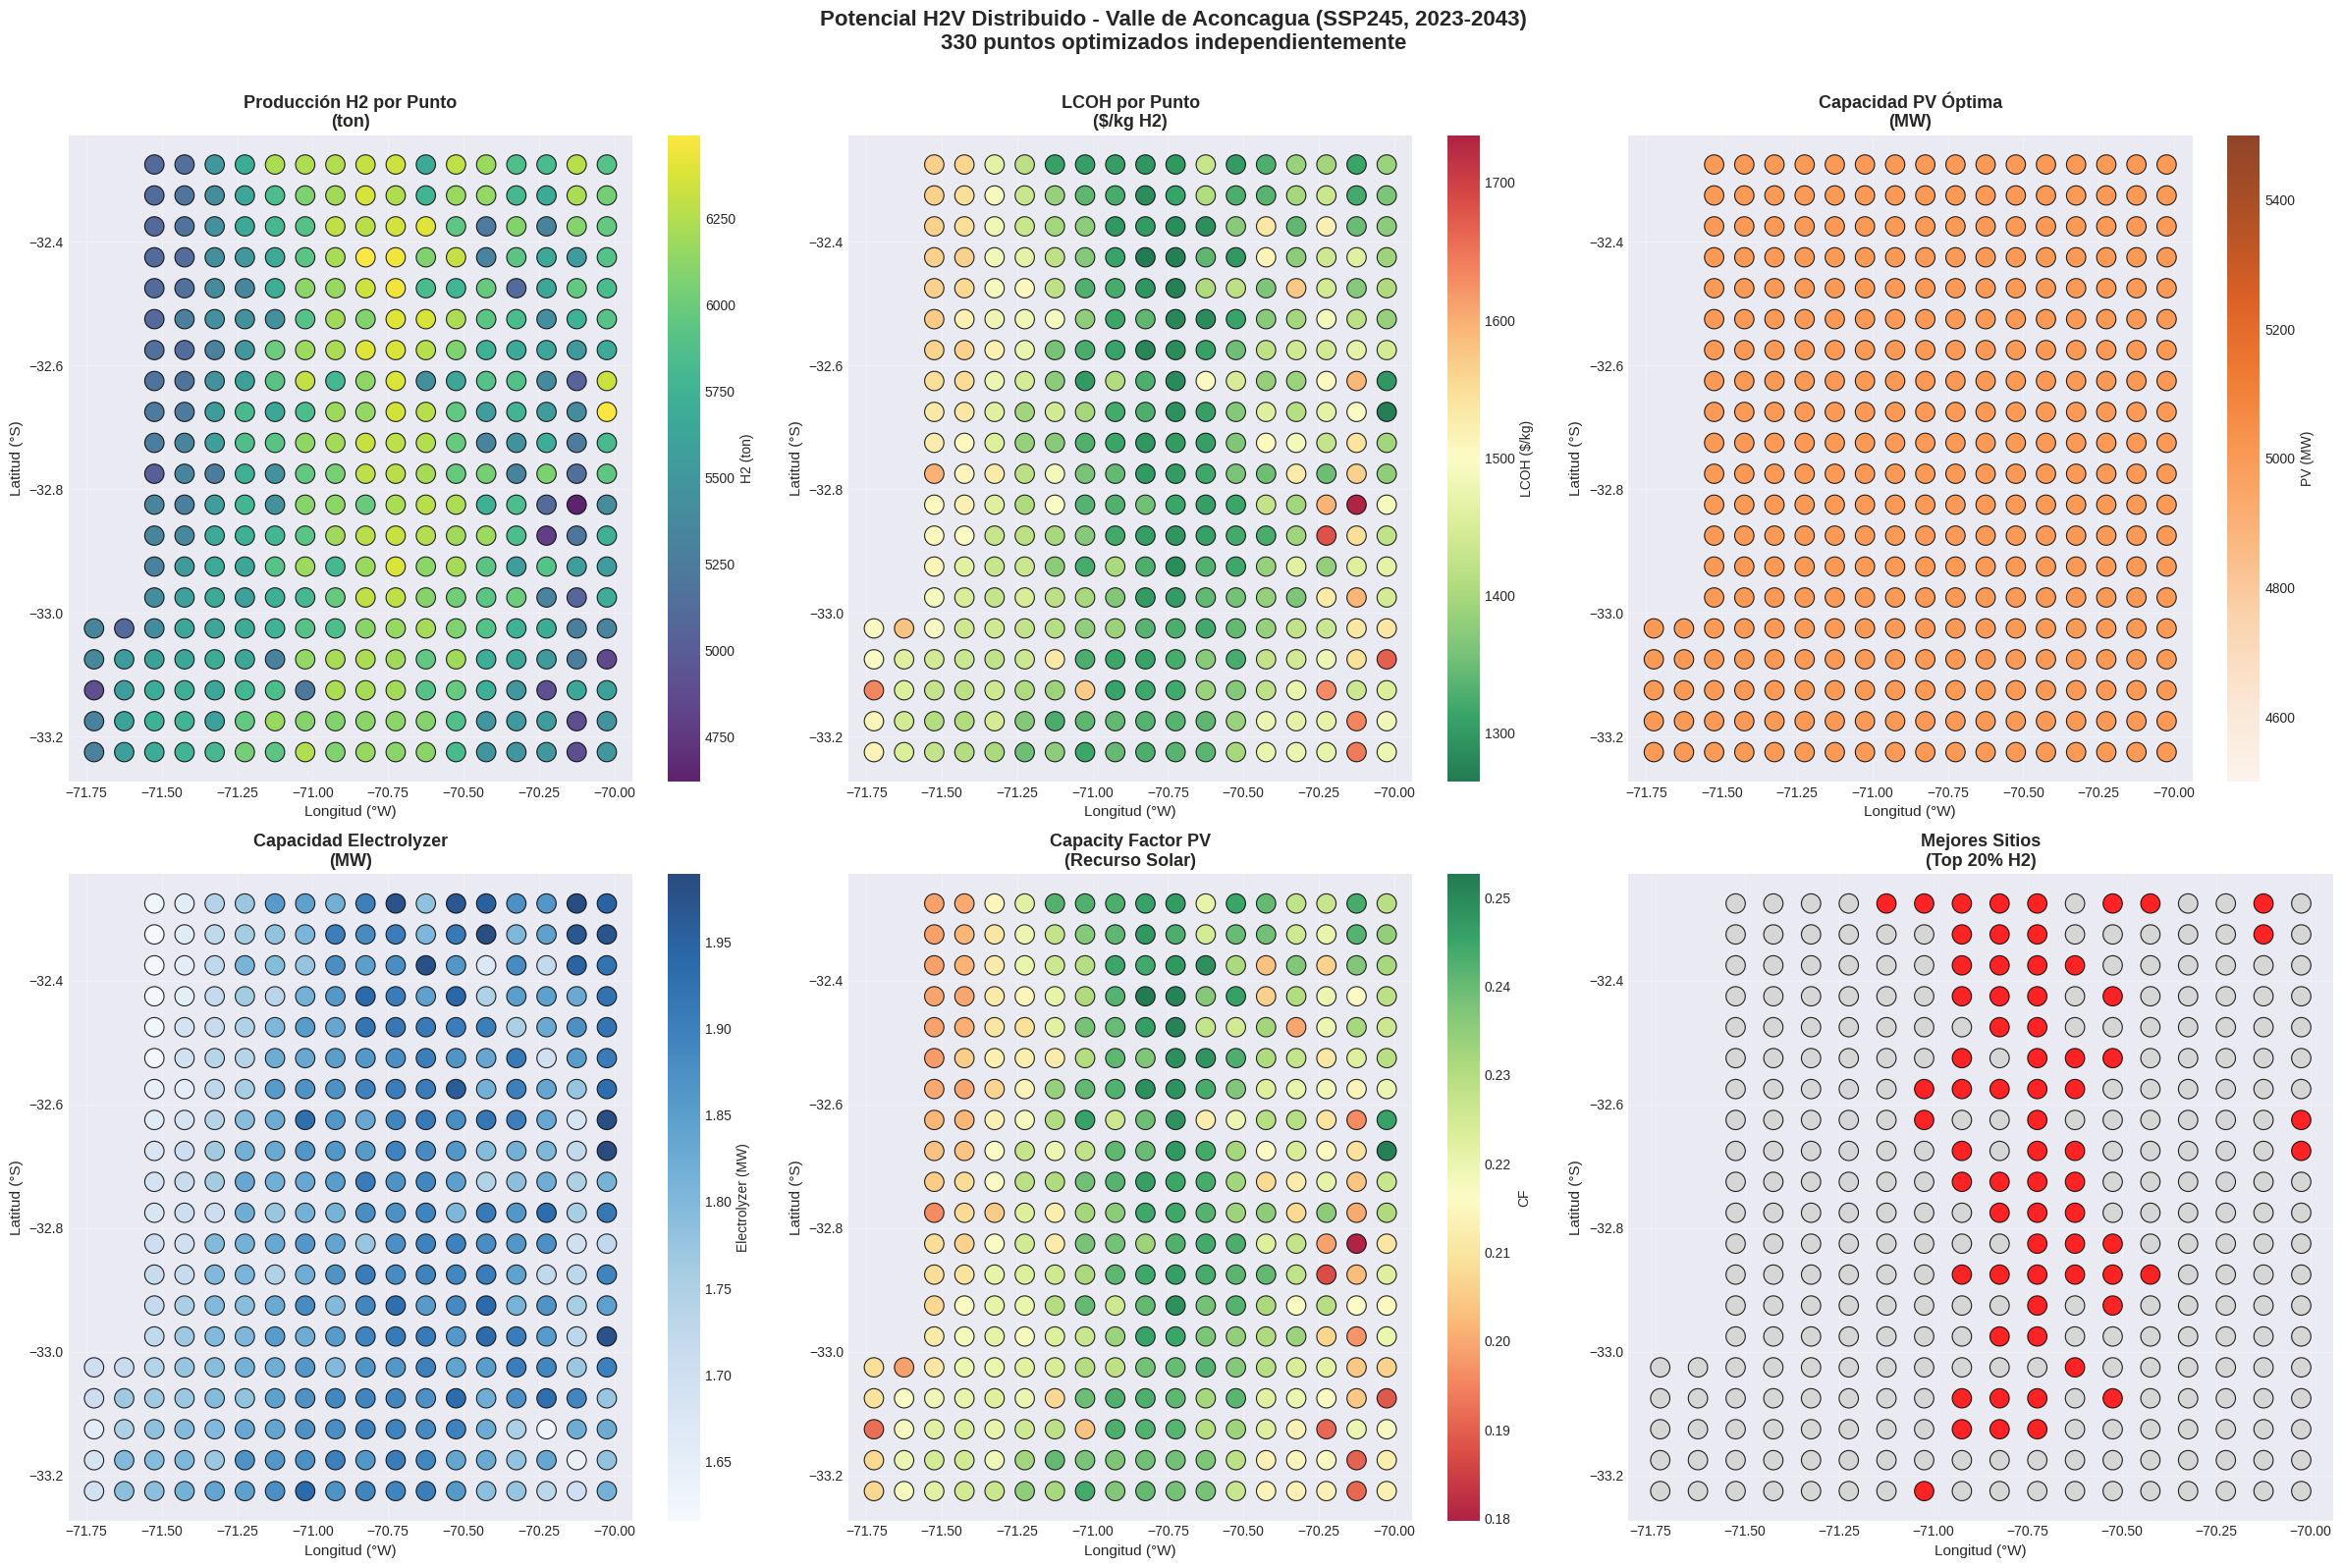

In [29]:
if len(df_success) == 0:
    print("⚠️ No hay resultados exitosos para visualizar")
else:
    print("Generando mapas espaciales...")
    
    fig, axes = plt.subplots(2, 3, figsize=(24, 16))
    
    # Mapa 1: Producción H2
    ax1 = axes[0, 0]
    scatter1 = ax1.scatter(df_success['lon'], df_success['lat'], 
                           c=df_success['h2_prod_ton'], s=200,
                           cmap='viridis', edgecolors='black', linewidth=0.8, alpha=0.85)
    ax1.set_title('Producción H2 por Punto\n(ton)', fontsize=13, fontweight='bold')
    ax1.set_xlabel('Longitud (°W)', fontsize=11)
    ax1.set_ylabel('Latitud (°S)', fontsize=11)
    ax1.grid(True, alpha=0.3)
    cbar1 = plt.colorbar(scatter1, ax=ax1)
    cbar1.set_label('H2 (ton)', fontsize=10)
    
    # Mapa 2: LCOH
    ax2 = axes[0, 1]
    scatter2 = ax2.scatter(df_success['lon'], df_success['lat'], 
                           c=df_success['lcoh_usd_kg'], s=200,
                           cmap='RdYlGn_r', edgecolors='black', linewidth=0.8, alpha=0.85)
    ax2.set_title('LCOH por Punto\n($/kg H2)', fontsize=13, fontweight='bold')
    ax2.set_xlabel('Longitud (°W)', fontsize=11)
    ax2.set_ylabel('Latitud (°S)', fontsize=11)
    ax2.grid(True, alpha=0.3)
    cbar2 = plt.colorbar(scatter2, ax=ax2)
    cbar2.set_label('LCOH ($/kg)', fontsize=10)
    
    # Mapa 3: Capacidad PV
    ax3 = axes[0, 2]
    scatter3 = ax3.scatter(df_success['lon'], df_success['lat'], 
                           c=df_success['cap_pv_mw'], s=200,
                           cmap='Oranges', edgecolors='black', linewidth=0.8, alpha=0.85)
    ax3.set_title('Capacidad PV Óptima\n(MW)', fontsize=13, fontweight='bold')
    ax3.set_xlabel('Longitud (°W)', fontsize=11)
    ax3.set_ylabel('Latitud (°S)', fontsize=11)
    ax3.grid(True, alpha=0.3)
    cbar3 = plt.colorbar(scatter3, ax=ax3)
    cbar3.set_label('PV (MW)', fontsize=10)
    
    # Mapa 4: Capacidad Electrolyzer
    ax4 = axes[1, 0]
    scatter4 = ax4.scatter(df_success['lon'], df_success['lat'], 
                           c=df_success['cap_electrolyzer_mw'], s=200,
                           cmap='Blues', edgecolors='black', linewidth=0.8, alpha=0.85)
    ax4.set_title('Capacidad Electrolyzer\n(MW)', fontsize=13, fontweight='bold')
    ax4.set_xlabel('Longitud (°W)', fontsize=11)
    ax4.set_ylabel('Latitud (°S)', fontsize=11)
    ax4.grid(True, alpha=0.3)
    cbar4 = plt.colorbar(scatter4, ax=ax4)
    cbar4.set_label('Electrolyzer (MW)', fontsize=10)
    
    # Mapa 5: CF Input
    ax5 = axes[1, 1]
    scatter5 = ax5.scatter(df_success['lon'], df_success['lat'], 
                           c=df_success['cf_mean'], s=200,
                           cmap='RdYlGn', edgecolors='black', linewidth=0.8, alpha=0.85)
    ax5.set_title('Capacity Factor PV\n(Recurso Solar)', fontsize=13, fontweight='bold')
    ax5.set_xlabel('Longitud (°W)', fontsize=11)
    ax5.set_ylabel('Latitud (°S)', fontsize=11)
    ax5.grid(True, alpha=0.3)
    cbar5 = plt.colorbar(scatter5, ax=ax5)
    cbar5.set_label('CF', fontsize=10)
    
    # Mapa 6: Ranking Top 20%
    ax6 = axes[1, 2]
    df_success['h2_percentile'] = df_success['h2_prod_ton'].rank(pct=True)
    top_20 = df_success['h2_percentile'] >= 0.8
    colors = ['red' if x else 'lightgray' for x in top_20]
    ax6.scatter(df_success['lon'], df_success['lat'], 
                c=colors, s=200,
                edgecolors='black', linewidth=0.8, alpha=0.85)
    ax6.set_title('Mejores Sitios\n(Top 20% H2)', fontsize=13, fontweight='bold')
    ax6.set_xlabel('Longitud (°W)', fontsize=11)
    ax6.set_ylabel('Latitud (°S)', fontsize=11)
    ax6.grid(True, alpha=0.3)
    
    # Título general
    period_str = "2023-2043" if TEST_MODE else "2015-2100"
    plt.suptitle(f'Potencial H2V Distribuido - Valle de Aconcagua ({SCENARIO.upper()}, {period_str})\n'
                 f'{len(df_success)} puntos optimizados independientemente',
                 fontsize=16, fontweight='bold', y=0.995)
    
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    
    # Guardar
    map_path = OUTPUT_DIR / f'spatial_maps_{SCENARIO}_{"test" if TEST_MODE else "full"}.png'
    plt.savefig(map_path, dpi=300, bbox_inches='tight')
    print(f"✅ Mapas guardados: {map_path.name}")
    
    plt.show()

## 9️⃣ Análisis de Sensibilidad - Identificar Zonas Óptimas

In [30]:
if len(df_success) > 0:
    print("=" * 80)
    print("🎯 ANÁLISIS DE ZONAS ÓPTIMAS")
    print("=" * 80)
    
    # Top 10%, 20%, 50% sitios por producción H2
    for pct in [10, 20, 50]:
        threshold = df_success['h2_prod_ton'].quantile(1 - pct/100)
        top_sites = df_success[df_success['h2_prod_ton'] >= threshold]
        
        print(f"\n📊 Top {pct}% Sitios por Producción H2:")
        print(f"   Umbral: {threshold:.1f} ton")
        print(f"   Número de sitios: {len(top_sites)}")
        print(f"   Producción total: {top_sites['h2_prod_ton'].sum():.1f} ton")
        print(f"   LCOH promedio: ${top_sites['lcoh_usd_kg'].mean():.2f}/kg")
        print(f"   CF promedio: {top_sites['cf_mean'].mean():.4f}")
        
        # Rango geográfico
        print(f"   Rango geográfico:")
        print(f"     Lat: {top_sites['lat'].min():.3f} a {top_sites['lat'].max():.3f}")
        print(f"     Lon: {top_sites['lon'].min():.3f} a {top_sites['lon'].max():.3f}")
    
    # Correlación CF vs H2 producido
    corr = df_success['cf_mean'].corr(df_success['h2_prod_ton'])
    print(f"\n📈 Correlación CF vs H2 producido: {corr:.3f}")
    
    print("=" * 80)

🎯 ANÁLISIS DE ZONAS ÓPTIMAS

📊 Top 10% Sitios por Producción H2:
   Umbral: 6262.3 ton
   Número de sitios: 33
   Producción total: 209297.9 ton
   LCOH promedio: $1291.58/kg
   CF promedio: 0.2469
   Rango geográfico:
     Lat: -32.975 a -32.275
     Lon: -71.025 a -70.025

📊 Top 20% Sitios por Producción H2:
   Umbral: 6174.4 ton
   Número de sitios: 66
   Producción total: 414505.1 ton
   LCOH promedio: $1303.03/kg
   CF promedio: 0.2446
   Rango geográfico:
     Lat: -33.225 a -32.275
     Lon: -71.125 a -70.025

📊 Top 50% Sitios por Producción H2:
   Umbral: 5784.5 ton
   Número de sitios: 165
   Producción total: 1006716.3 ton
   LCOH promedio: $1339.42/kg
   CF promedio: 0.2377
   Rango geográfico:
     Lat: -33.225 a -32.275
     Lon: -71.325 a -70.025

📈 Correlación CF vs H2 producido: 1.000


---

## ✅ Resumen Final

Este notebook implementa un **modelo distribuido punto por punto** para evaluar el potencial de producción de H2V en el Valle de Aconcagua.

### Outputs Generados:
1. **CSV**: Matriz de resultados (`h2_distributed_{scenario}_{mode}.csv`)
2. **Mapas**: 6 visualizaciones espaciales de capacidades, producción, LCOH, ranking
3. **Análisis**: Top sitios, correlaciones, zonas óptimas

### Para Ejecutar con Todos los Puntos (330):
```python
N_POINTS_SAMPLE = None  # Procesar todos
TEST_MODE = False       # Período completo 2015-2100
```

**Tiempo estimado**: ~1.5 horas (330 puntos × 15s)

---

## 🚀 EJECUTAR TODOS LOS PUNTOS (330)

**⚠️ IMPORTANTE**: Esto tomará aproximadamente:
- **Test mode (2023-2043)**: ~7-10 minutos
- **Full mode (2015-2100)**: ~30-45 minutos

Cambia la configuración y vuelve a ejecutar desde la celda de configuración.

In [26]:
# ========== CONFIGURACIÓN PARA TODOS LOS PUNTOS ==========

# CAMBIAR ESTOS VALORES Y RE-EJECUTAR:
N_POINTS_SAMPLE_FULL = None  # None = todos los 330 puntos
TEST_MODE_FULL = True         # True = 2023-2043 (~7 min), False = 2015-2100 (~45 min)

print("=" * 80)
print("🚀 CONFIGURACIÓN PARA EJECUCIÓN COMPLETA")
print("=" * 80)
print(f"\n📍 Puntos a procesar: {N_POINTS_SAMPLE_FULL if N_POINTS_SAMPLE_FULL else '330 (TODOS)'}")
print(f"📅 Período: {'2023-2043 (TEST)' if TEST_MODE_FULL else '2015-2100 (FULL)'}")

# Estimación de tiempo
n_points_estimate = N_POINTS_SAMPLE_FULL if N_POINTS_SAMPLE_FULL else 330
time_per_point_estimate = 1.5 if TEST_MODE_FULL else 8  # segundos
total_minutes = (n_points_estimate * time_per_point_estimate) / 60

print(f"\n⏱️  Tiempo estimado: {total_minutes:.1f} minutos ({total_minutes/60:.1f} horas)")
print(f"   ({n_points_estimate} puntos × ~{time_per_point_estimate}s/punto)")

print("\n" + "=" * 80)
print("⚠️  PASOS PARA EJECUTAR:")
print("=" * 80)
print("1. Verifica que N_POINTS_SAMPLE_FULL y TEST_MODE_FULL tengan los valores deseados")
print("2. Re-ejecuta la celda de CONFIGURACIÓN (celda 5) con estos nuevos valores:")
print("   - Cambia N_POINTS_SAMPLE = N_POINTS_SAMPLE_FULL")
print("   - Cambia TEST_MODE = TEST_MODE_FULL")
print("3. Re-ejecuta las celdas de datos (celda 7)")
print("4. Re-ejecuta las funciones (celdas 9 y 11)")
print("5. Re-ejecuta el LOOP PRINCIPAL (celda 13)")
print("6. Re-ejecuta consolidación y visualización (celdas 15, 18, 20)")
print("\n💡 TIP: O simplemente copia los valores de arriba a la celda 5 y ejecuta todo desde ahí")
print("=" * 80)

🚀 CONFIGURACIÓN PARA EJECUCIÓN COMPLETA

📍 Puntos a procesar: 330 (TODOS)
📅 Período: 2023-2043 (TEST)

⏱️  Tiempo estimado: 8.2 minutos (0.1 horas)
   (330 puntos × ~1.5s/punto)

⚠️  PASOS PARA EJECUTAR:
1. Verifica que N_POINTS_SAMPLE_FULL y TEST_MODE_FULL tengan los valores deseados
2. Re-ejecuta la celda de CONFIGURACIÓN (celda 5) con estos nuevos valores:
   - Cambia N_POINTS_SAMPLE = N_POINTS_SAMPLE_FULL
   - Cambia TEST_MODE = TEST_MODE_FULL
3. Re-ejecuta las celdas de datos (celda 7)
4. Re-ejecuta las funciones (celdas 9 y 11)
5. Re-ejecuta el LOOP PRINCIPAL (celda 13)
6. Re-ejecuta consolidación y visualización (celdas 15, 18, 20)

💡 TIP: O simplemente copia los valores de arriba a la celda 5 y ejecuta todo desde ahí


## 🔄 Ejecutar Otros Escenarios (SSP370, SSP585)

In [33]:
# ========== EJECUTAR MÚLTIPLES ESCENARIOS ==========
# Esta celda ejecuta SSP370 y SSP585 automáticamente

import time

# Escenarios pendientes (SSP245 ya ejecutado)
scenarios_to_run = ['ssp370', 'ssp585']

# Guardar resultados de todos los escenarios
all_scenarios_results = {}

for scenario in scenarios_to_run:
    print("\n" + "=" * 80)
    print(f"🌍 PROCESANDO ESCENARIO: {scenario.upper()}")
    print("=" * 80)
    
    # 1. Actualizar SCENARIO
    SCENARIO = scenario
    
    # 2. Cargar datos CF del nuevo escenario
    print(f"Cargando datos PV CF para {scenario}...")
    cf_file = PV_CF_DIR / f'pv_cf_{scenario}.nc'
    
    if not cf_file.exists():
        print(f"⚠️ Archivo no encontrado: {cf_file}")
        print(f"   Saltando escenario {scenario}")
        continue
    
    ds_cf = xr.open_dataset(cf_file)
    print(f"✓ Dataset cargado: {cf_file.name}")
    
    # Identificar variable CF
    cf_var = 'cf_monthly'
    if cf_var not in ds_cf:
        cf_var = list(ds_cf.data_vars)[0]
    
    # Crear máscara de puntos válidos
    valid_mask = ~ds_cf['cf_spatial_mean'].isnull()
    n_valid = valid_mask.sum().values
    print(f"✓ Puntos válidos: {n_valid}")
    
    # 3. Preparar lista de puntos
    print(f"Preparando lista de puntos para {scenario}...")
    points_list = []
    point_idx = 1
    
    for i, lat in enumerate(ds_cf.lat.values):
        for j, lon in enumerate(ds_cf.lon.values):
            if valid_mask.values[i, j]:
                cf_series = ds_cf[cf_var].isel(lat=i, lon=j).to_pandas()
                points_list.append({
                    'point_id': point_idx,
                    'lat': float(lat),
                    'lon': float(lon),
                    'cf_series': cf_series,
                    'i': i,
                    'j': j
                })
                point_idx += 1
    
    # Limitar a muestra si necesario
    if N_POINTS_SAMPLE:
        step = max(1, len(points_list) // N_POINTS_SAMPLE)
        points_list = points_list[::step][:N_POINTS_SAMPLE]
    
    print(f"✓ {len(points_list)} puntos listos para procesar")
    
    # 4. EJECUTAR OPTIMIZACIÓN
    print(f"\n🚀 INICIANDO OPTIMIZACIÓN: {scenario.upper()}")
    print("=" * 80)
    
    results_list = []
    start_time = datetime.datetime.now()
    
    for idx, point_info in enumerate(points_list, 1):
        # Preparar datos del punto
        point_data = prepare_point_data(
            lat=point_info['lat'],
            lon=point_info['lon'],
            cf_series=point_info['cf_series'],
            point_id=point_info['point_id'],
            output_dir=OUTPUT_DIR / scenario,  # Subdirectorio por escenario
            demand_mwh=DEMAND_PER_POINT_MWh
        )
        
        # Ejecutar modelo
        result = run_point_model(
            point_data=point_data,
            techs_yml_path=TECHS_YML,
            test_mode=TEST_MODE
        )
        
        results_list.append(result)
        
        # Progreso
        elapsed = (datetime.datetime.now() - start_time).total_seconds()
        rate = idx / elapsed if elapsed > 0 else 0
        remaining = (len(points_list) - idx) / rate if rate > 0 else 0
        
        status_icon = "✓" if result['status'] == 'success' else "✗"
        h2_val = f"{result.get('h2_prod_ton', 0):.1f}" if result['status'] == 'success' else "N/A"
        
        if idx % 10 == 0 or idx == len(points_list):  # Mostrar cada 10 puntos
            print(f"  [{idx:3d}/{len(points_list)}] {status_icon} Punto {point_info['point_id']:3d} "
                  f"({point_info['lat']:.3f}, {point_info['lon']:.3f}) | "
                  f"H2: {h2_val} ton | "
                  f"Restante: {remaining/60:.1f} min")
    
    elapsed_total = (datetime.datetime.now() - start_time).total_seconds()
    
    print("\n" + "=" * 80)
    print(f"✅ {scenario.upper()} COMPLETADO")
    print("=" * 80)
    print(f"⏱️  Tiempo total: {elapsed_total:.1f}s ({elapsed_total/60:.1f} min)")
    print(f"📊 Puntos procesados: {len(results_list)}")
    print(f"   Exitosos: {sum(1 for r in results_list if r['status'] == 'success')}")
    print(f"   Fallidos: {sum(1 for r in results_list if r['status'] == 'failed')}")
    print("=" * 80)
    
    # 5. Consolidar y guardar
    df_results = pd.DataFrame(results_list)
    df_success = df_results[df_results['status'] == 'success'].copy()
    
    mode_str = 'test' if TEST_MODE else 'full'
    csv_path = OUTPUT_DIR / f'h2_distributed_{scenario}_{mode_str}.csv'
    df_results.to_csv(csv_path, index=False)
    print(f"💾 CSV guardado: {csv_path.name}")
    
    # Guardar para análisis comparativo
    all_scenarios_results[scenario] = {
        'df_results': df_results,
        'df_success': df_success,
        'elapsed_time': elapsed_total
    }
    
    print(f"\n✓ Escenario {scenario.upper()} guardado en memoria para análisis comparativo")
    
    # Pequeña pausa entre escenarios
    time.sleep(2)

print("\n\n" + "=" * 80)
print("🎉 TODOS LOS ESCENARIOS COMPLETADOS")
print("=" * 80)
print("Escenarios procesados:")
for scenario, data in all_scenarios_results.items():
    success_count = len(data['df_success'])
    total_count = len(data['df_results'])
    print(f"  {scenario.upper()}: {success_count}/{total_count} puntos exitosos ({data['elapsed_time']/60:.1f} min)")
print("=" * 80)


🌍 PROCESANDO ESCENARIO: SSP370
Cargando datos PV CF para ssp370...
✓ Dataset cargado: pv_cf_ssp370.nc
✓ Puntos válidos: 330
Preparando lista de puntos para ssp370...
✓ 330 puntos listos para procesar

🚀 INICIANDO OPTIMIZACIÓN: SSP370
  [ 10/330] ✓ Punto  10 (-33.225, -70.825) | H2: 6140.2 ton | Restante: 8.2 min
  [ 20/330] ✓ Punto  20 (-33.175, -71.625) | H2: 5576.5 ton | Restante: 5.8 min
  [ 30/330] ✓ Punto  30 (-33.175, -70.625) | H2: 6077.0 ton | Restante: 4.9 min
  [ 40/330] ✓ Punto  40 (-33.125, -71.425) | H2: 5686.1 ton | Restante: 4.4 min
  [ 50/330] ✓ Punto  50 (-33.125, -70.425) | H2: 5691.2 ton | Restante: 4.1 min
  [ 60/330] ✓ Punto  60 (-33.075, -71.225) | H2: 5599.5 ton | Restante: 3.8 min
  [ 70/330] ✓ Punto  70 (-33.075, -70.225) | H2: 5519.8 ton | Restante: 3.6 min
  [ 80/330] ✓ Punto  80 (-33.025, -71.025) | H2: 5888.6 ton | Restante: 3.9 min
  [ 90/330] ✓ Punto  90 (-33.025, -70.025) | H2: 5279.0 ton | Restante: 3.6 min
  [100/330] ✓ Punto 100 (-32.975, -70.625) | 

## 📊 Análisis Comparativo Entre Escenarios

In [34]:
# ========== COMPARACIÓN ENTRE ESCENARIOS SSP ==========

# Cargar resultados de SSP245 si no está en memoria
if 'ssp245' not in all_scenarios_results:
    print("Cargando resultados SSP245...")
    mode_str = 'test' if TEST_MODE else 'full'
    csv_ssp245 = OUTPUT_DIR / f'h2_distributed_ssp245_{mode_str}.csv'
    if csv_ssp245.exists():
        df_ssp245 = pd.read_csv(csv_ssp245)
        all_scenarios_results['ssp245'] = {
            'df_results': df_ssp245,
            'df_success': df_ssp245[df_ssp245['status'] == 'success']
        }
        print("✓ SSP245 cargado")
    else:
        print(f"⚠️ No se encontró: {csv_ssp245}")

# Crear DataFrame comparativo
print("\n" + "=" * 80)
print("📊 COMPARACIÓN ENTRE ESCENARIOS SSP")
print("=" * 80)

comparison_stats = []

for scenario in ['ssp245', 'ssp370', 'ssp585']:
    if scenario in all_scenarios_results:
        df_success = all_scenarios_results[scenario]['df_success']
        
        if len(df_success) > 0:
            stats = {
                'Escenario': scenario.upper(),
                'Puntos_exitosos': len(df_success),
                'H2_total_ton': df_success['h2_prod_ton'].sum(),
                'H2_promedio_ton': df_success['h2_prod_ton'].mean(),
                'H2_max_ton': df_success['h2_prod_ton'].max(),
                'H2_min_ton': df_success['h2_prod_ton'].min(),
                'LCOH_promedio_usd_kg': df_success['lcoh_usd_kg'].mean(),
                'LCOH_min_usd_kg': df_success['lcoh_usd_kg'].min(),
                'LCOH_max_usd_kg': df_success['lcoh_usd_kg'].max(),
                'Cap_PV_promedio_MW': df_success['cap_pv_mw'].mean(),
                'Cap_Electrolyzer_promedio_MW': df_success['cap_electrolyzer_mw'].mean(),
                'CF_promedio': df_success['cf_mean'].mean()
            }
            comparison_stats.append(stats)

df_comparison = pd.DataFrame(comparison_stats)

print("\n📈 Resumen por Escenario:")
print(df_comparison.to_string(index=False))

# Calcular diferencias relativas respecto a SSP245
if len(df_comparison) >= 2:
    print("\n\n📊 DIFERENCIAS RELATIVAS (respecto a SSP245):")
    print("=" * 80)
    
    baseline = df_comparison[df_comparison['Escenario'] == 'SSP245'].iloc[0]
    
    for _, row in df_comparison.iterrows():
        if row['Escenario'] != 'SSP245':
            print(f"\n{row['Escenario']} vs SSP245:")
            
            h2_diff = ((row['H2_total_ton'] - baseline['H2_total_ton']) / baseline['H2_total_ton']) * 100
            lcoh_diff = ((row['LCOH_promedio_usd_kg'] - baseline['LCOH_promedio_usd_kg']) / baseline['LCOH_promedio_usd_kg']) * 100
            cf_diff = ((row['CF_promedio'] - baseline['CF_promedio']) / baseline['CF_promedio']) * 100
            
            print(f"  H2 Total: {h2_diff:+.2f}%")
            print(f"  LCOH Promedio: {lcoh_diff:+.2f}%")
            print(f"  CF Promedio: {cf_diff:+.2f}%")

print("\n" + "=" * 80)

# Guardar comparación
mode_str = 'test' if TEST_MODE else 'full'
comparison_csv = OUTPUT_DIR / f'comparison_scenarios_{mode_str}.csv'
df_comparison.to_csv(comparison_csv, index=False)
print(f"\n💾 Comparación guardada: {comparison_csv.name}")

Cargando resultados SSP245...
✓ SSP245 cargado

📊 COMPARACIÓN ENTRE ESCENARIOS SSP

📈 Resumen por Escenario:
Escenario  Puntos_exitosos  H2_total_ton  H2_promedio_ton  H2_max_ton  H2_min_ton  LCOH_promedio_usd_kg  LCOH_min_usd_kg  LCOH_max_usd_kg  Cap_PV_promedio_MW  Cap_Electrolyzer_promedio_MW  CF_promedio
   SSP245              330  1.904841e+06      5772.245368 6490.819737 4622.278992           1413.602206      1264.541370      1734.509245              5000.0                      1.824276     0.224917
   SSP370              330  1.901220e+06      5761.273127 6490.911536 4616.391590           1415.432443      1265.135466      1734.726831              5000.0                      1.816823     0.224337
   SSP585              330  1.930515e+06      5850.046186 6564.028318 4693.392313           1396.694759      1252.965319      1710.586293              5000.0                      1.828324     0.227035


📊 DIFERENCIAS RELATIVAS (respecto a SSP245):

SSP370 vs SSP245:
  H2 Total: -0.19%
  